In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from IPython.display import HTML, display
import tabulate
import os
import scipy.linalg.blas
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [2]:
def analyze(resultsDir, modelName, thinning, numberOfSamplesPerTimeStamp=1000):
    models = [modelName + mcmc for mcmc in ['_CHRR_nopt_0', '_CHRR_nopt_1', '_HRR_nopt_1']] #'_HRpt_0']]
    timestampsData = [
        pd.read_csv(os.path.join(resultsDir, model, model + "_timestamps.csv"), header=None).tail(10000) for model in models
    ]
    
    durations = [
        (data.iloc[-1, 0] - data.iloc[0, 0]) 
        #/ 1000
        #/ thinning / ( numberOfSamplesPerTimeStamp * len(data.index)-1)
        for data in timestampsData
    ]
   
    for i in range(len(models)):
        print(models[i] + ": " + str(durations[i]))

    return durations, models

In [3]:
durations_ecoli, chains_ecoli = analyze('results_hops_25_05_20', 'ecoliBoxConstr', 270)


ecoliBoxConstr_CHRR_nopt_0: 4649061
ecoliBoxConstr_CHRR_nopt_1: 7149183
ecoliBoxConstr_HRR_nopt_1: 7233558


In [4]:
def meanOfVecList(inlist):
    means = inlist[0]
    for i in range(1,len(inlist)):
        means+=inlist[i]
    means/=len(inlist)
    #print('means ' + str(means))
    return means

In [5]:
def PSRF(data):
    #print('call psrf')
    n = min([len(d) for d in data])
    #print("n " + str(n))
    #print(len(data))
    #print(data[0].mean())
    #print(n)
    variances = [vals.std(ddof=1)**2 for vals in data]
    if all(v < 1e-15 for v in variances):
        #print('variances: ' + str(variances))
        return 1
    

    variancesMean = np.array(variances).mean()
    #print('variancesMean ' + str(variancesMean))
    means = [vals.mean() for vals in data]
    meansMean = np.array(means).mean()
    #print("means size " + str(len(means)))
    W = np.array(variancesMean)
    B = np.add.reduce((np.array(means)-meansMean).std(ddof=1)**2)
    varEst = (n - 1.)/n * W  + B
    
    #print('R**2: ' + str(varEst / W))
    #print('R: ' + str(np.sqrt(varEst / W)))  
    return np.sqrt(varEst / W)

In [6]:
def calculatePSRF(resultsDir, chains):
    print("chains")
    print(chains)
    print(resultsDir)
    
    h = pd.read_csv(os.path.join(resultsDir, chains[0], chains[0] + "_parameterNames.csv"), header=None)[0].tolist()
    
    states = [ 
        pd.read_csv(os.path.join(resultsDir, chain, chain + "_states.csv"), header=None)
        for chain in chains
    ]
  
    psrfs = []

    for i in range(len(states[0].columns)):
        #print('dimensions ' + str(i))
        samples = sum([np.split(state.iloc[:,i].to_numpy(), 5) for state in states], [])
        psrfs.append(PSRF(samples))
    return psrfs, states,h

In [7]:
def printPSRF(chains, model):
    psrfs, states, header = calculatePSRF('results_hops_25_05_20', chains)
    print(model + " max psrf: " + str(max(psrfs)) + ", mean: " + str(np.array(psrfs).mean()) + " +/- " + str(np.array(psrfs).std()))
    return states, header

In [8]:
states_ecoli_all_chains, header = printPSRF(chains_ecoli, 'ecoliBoxConstr')

chains
['ecoliBoxConstr_CHRR_nopt_0', 'ecoliBoxConstr_CHRR_nopt_1', 'ecoliBoxConstr_HRR_nopt_1']
results_hops_25_05_20
ecoliBoxConstr max psrf: 1.0630108120793553, mean: 1.0119905507805036 +/- 0.015057563933982537


In [113]:
def plot(chains, states, header):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    plt.figure(figsize=(12,9))
    for n in range(len(states[0].columns)):
        plt.subplot(6, 5, n+1)
        #plt.title(titel + 'flux ' + str(n))
        #for j in range(len(states)):
        s = states[0][states[0].columns[n]].tolist() + states[1][states[1].columns[n]].tolist()
        plt.hist(s, 20, density=True)
        #plt.grid()
        plt.ylabel(r"density", fontsize=13)
        plt.xlabel(r'flux~[$mmol / g_{dw} / h$]',fontsize=13)
        plt.tight_layout()
        h = header[n].replace("_", "\_")
        title = h
        plt.title(title, fontsize=13)
    plt.savefig('figures/ecoliBoxConstrFluxes.pdf', format='pdf')
    plt.show()

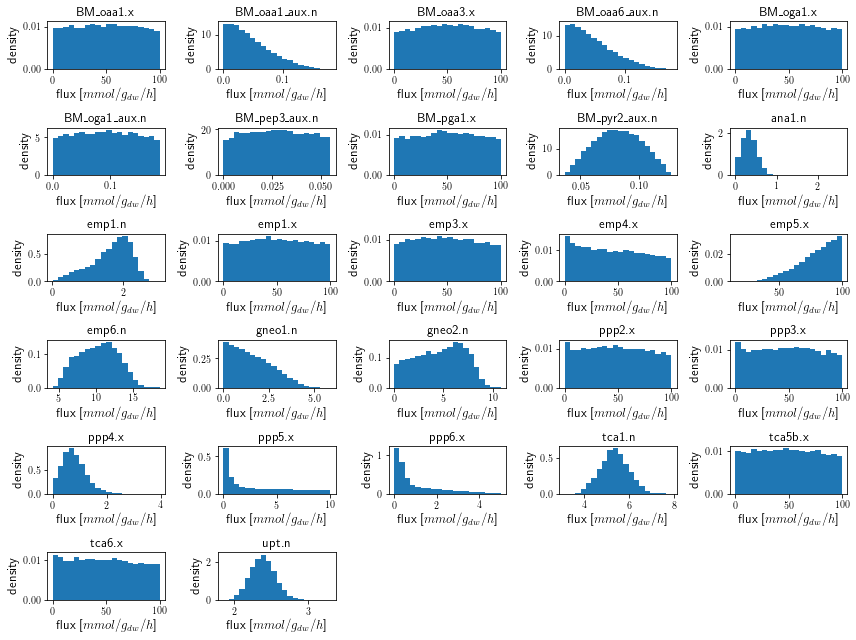

In [114]:
plot(chains_ecoli, states_ecoli_all_chains[:-1], header)

In [115]:
def effectiveSampleSize(samples, monotSensitivity=0.01):
    length = float(len(samples))
    
    mean = sum(samples) / length
    shiftedSamples = np.array([x-mean for x in samples], float, order="F")
    gamma = [(scipy.linalg.blas.ddot(shiftedSamples, shiftedSamples, offx=i) / length) for i in range(len(samples))]
    monot = next(i for i,g in enumerate(gamma) if g < monotSensitivity*gamma[0])
    gammaSum = sum(gamma[1:monot])
    v = (gamma[0] + 2*gammaSum) / length
    ess = gamma[0] / float(v)
    return ess

In [116]:
def calculatePSRFForN(resultsDir, chains, n):
    h = pd.read_csv(os.path.join(resultsDir, chains[0], chains[0] + "_parameterNames.csv"), header=None)[0].tolist()
    
    states = [ 
        pd.read_csv(os.path.join(resultsDir, chain, chain + "_states.csv"), header=None).head(n)
        for chain in chains
    ]
  
    psrfs = []
    for i in range(len(states[0].columns)):
        #print('dimensions ' + str(i))
        samples = sum([np.split(state.iloc[:,i].to_numpy(), 5) for state in states], [])
        psrfs.append(PSRF(samples))
    return max(psrfs)

In [119]:
psrfs = [calculatePSRFForN('results_hops_25_05_20', chains_ecoli,n) for n in range(100, 10100, 100)]

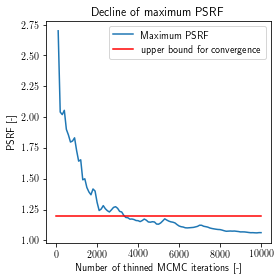

In [125]:
plt.figure(figsize=(4,4))
plt.xlabel("Number of thinned MCMC iterations~[-]")
plt.ylabel("PSRF~[-]")

plt.title("Decline of maximum PSRF")
plt.plot([n for n in range(100, 10100, 100)], psrfs, label='Maximum PSRF')
plt.plot([0, 10000], [1.2, 1.2], color='red', label="upper bound for convergence")
#plt.plot([3500, 3500], [1.2, min(psrfs)], color='red', label="point of convergence")
plt.legend()
plt.tight_layout()

plt.savefig("figures/ecoliBoxConstr_decliningPSRF.pdf", formmat="pdf")
plt.show()